# Lab 6: Machine Learning for Regression Analysis

## Introduction
The aim of the script is to model aboveground biomass density (AGBD) using the Global Ecosystem Dynamics Investigation (GEDI) Level 4A (L4A), Sentinel-2 (S2), Normalized Difference Vegetation Index (NDVI), Canopy Chlorophyll Content Index (CCCI), Specific Leaf Area Vegetation Index (SLAVI), and a random forest model.

Check tutorial for preparing biomass density training data
1. Creating a Training Dataset for Machine Learning | Part 1: GEDI L4A Data Preparation (https://www.youtube.com/watch?v=6y0Ya1dTecI&t=63s)
2. Creating a Training Dataset for Machine Learning | Part 2: Combining with Sentinel-2 (https://www.youtube.com/watch?v=WDAhFphWb98)

Following are the steps to model AGBD (model 2).

## Install Libraries

Install the necessary libraries.

In [ ]:
# Install some packages
!pip install rasterio
!pip install earthpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.8 MB/s eta 0:00:00


Next, import the following libraries.

In [ ]:
# Import the libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.features import rasterize
import earthpy.plot as ep
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Setting-up Colab
## Mount your Google Drive
First, make sure that your data is loaded in Google Drive. After that mount your Google Drive using the code below.

In [ ]:
# Import the neccessary library
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Access the raster and vector datasets
Import the raster  and vector datasets. Prepare the features and labels.

In [ ]:
# Prepare the parameters
FEATURES = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12','NDVI','CCCI','SLAVI']
LABEL = ['agbd']
SAMPLE_PATH = '/content/drive/My Drive/Maf_Datasets/SampleAGBD_Filtered21.csv' # With filtered agbd
IMAGE_PATH = '/content/drive/My Drive/Maf_Datasets/Maf_prs_S2_VI_2021.tif'

## Create image composites
Load and display the imagery.

/usr/local/lib/python3.11/dist-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


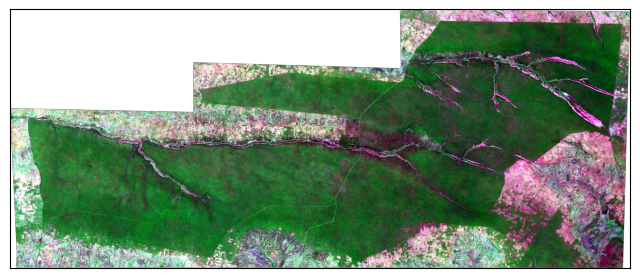

<Axes: >

In [ ]:
# Load the image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [9, 7, 2]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

# Prepare datasets for modeling
## Import the sample data

Next, we are going to load the sample data with the aboveground biomass density (AGBD) and raster variables.

In [ ]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)[FEATURES + LABEL]
samples

,B2,B3,B4,B5,B6,B7,B8,B11,B12,NDVI,CCCI,SLAVI,agbd
0,0.222036,0.295804,0.299917,0.392492,0.476917,0.497092,0.502394,0.474763,0.405709,0.737257,0.605276,0.900190,0
1,0.223942,0.272121,0.315991,0.364280,0.427785,0.455467,0.472229,0.513858,0.420773,0.690723,0.557430,0.806403,0
2,0.248998,0.302242,0.356511,0.393891,0.448163,0.471646,0.487750,0.534696,0.443001,0.651781,0.547967,0.788015,0
3,0.202855,0.260192,0.286705,0.374366,0.452161,0.475289,0.480416,0.490918,0.390768,0.737380,0.601825,0.857055,0
4,0.247891,0.308545,0.372827,0.416173,0.451774,0.472493,0.491121,0.584294,0.522303,0.634403,0.469261,0.751041,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4528,0.172047,0.207846,0.205426,0.260768,0.374700,0.412068,0.435431,0.436692,0.335261,0.817947,0.627815,0.907042,136
4529,0.174929,0.210000,0.208806,0.292233,0.403980,0.437493,0.443959,0.460869,0.365650,0.818862,0.595828,0.884961,137
4530,0.179165,0.205183,0.229565,0.313050,0.394081,0.424735,0.380526,0.487545,0.398121,0.733165,0.477415,0.749311,138
4531,0.170000,0.213542,0.192614,0.251992,0.411461,0.452327,0.485386,0.411218,0.293769,0.863953,0.731904,1.000000,139


## Split training data
First, let's split the training points into training and test datasets.

In [ ]:
# Split into train and test
train, test = train_test_split(samples, test_size=0.2, shuffle=True, random_state=42)

# Get variables input and output
X_train = train[FEATURES]
X_test = test[FEATURES]
y_train = train[LABEL].astype(float)
y_test = test[LABEL].astype(float)

# Show the data shape
print(f'Train features: {X_train.shape}\nTest features: {X_test.shape}\nTrain label: {y_train.shape}\nTest label: {y_test.shape}')

Train features: (3626, 12)
Test features: (907, 12)
Train label: (3626, 1)
Test label: (907, 1)


## Perform exploratory data analysis (EDA)
Exploratory data analysis (EDA) is an important step in understanding your data before building a machine learning model. To perform EDA on your training dataset, we will use libraries such as pandas for data manipulation and matplotlib or seaborn for data visualization. First, we will start by creating a DataFrame for the training dataset.

In [ ]:
# Create a DataFrame from X_train and y_train
train_df = pd.DataFrame(data=np.c_[X_train, y_train], columns=[f'Band_{i}' for i in range(X_train.shape[1])] + ['agbd'])

# Rename columns in the DataFrame train_df
train_df.columns = FEATURES + ['agbd']

We will take a quick look at the top five rows using the DataFrame's head() method.

In [ ]:
# Check the first five rows
train_df.head()

,B2,B3,B4,B5,B6,B7,B8,B11,B12,NDVI,CCCI,SLAVI,agbd
0,0.203470,0.248697,0.253673,0.322025,0.433186,0.462601,0.475552,0.472758,0.390384,0.778485,0.597411,0.892826,48.0
1,0.234734,0.295635,0.325269,0.408779,0.478644,0.508724,0.524786,0.527541,0.446206,0.722455,0.580400,0.858500,1.0
2,0.166733,0.202485,0.186011,0.283373,0.417493,0.457384,0.457930,0.427902,0.324345,0.858371,0.665926,0.981626,80.0
3,0.244336,0.301662,0.315753,0.392046,0.476603,0.497041,0.513420,0.535397,0.465349,0.725571,0.548995,0.841141,5.0
4,0.172337,0.223271,0.230868,0.289914,0.443621,0.476760,0.478801,0.456508,0.350927,0.811361,0.650539,0.938002,40.0


Let's use the info() method to get a quick description of the data.

In [ ]:
# Use the info()to check the data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3626 entries, 0 to 3625
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   B2      3626 non-null   float64
 1   B3      3626 non-null   float64
 2   B4      3626 non-null   float64
 3   B5      3626 non-null   float64
 4   B6      3626 non-null   float64
 5   B7      3626 non-null   float64
 6   B8      3626 non-null   float64
 7   B11     3626 non-null   float64
 8   B12     3626 non-null   float64
 9   NDVI    3626 non-null   float64
 10  CCCI    3626 non-null   float64
 11  SLAVI   3626 non-null   float64
 12  agbd    3626 non-null   float64
dtypes: float64(13)
memory usage: 368.4 KB


Next, we will use the describe() method to get summary statistics of the training dataset. This will provide statistics such as mean, standard deviation, minimum, maximum, and quartiles for each feature and the target variable.

In [ ]:
# Print summary statistics
summary_stats = train_df.describe()
print(summary_stats)

                B2           B3           B4           B5           B6  \
count  3626.000000  3626.000000  3626.000000  3626.000000  3626.000000   
mean      0.200594     0.248594     0.262071     0.328128     0.442655   
std       0.037481     0.044861     0.070788     0.060915     0.034574   
min       0.132288     0.169558     0.146287     0.230868     0.357351   
25%       0.172482     0.214243     0.205426     0.279844     0.418569   
50%       0.187883     0.232755     0.237697     0.302655     0.435316   
75%       0.224805     0.279777     0.314325     0.375067     0.461086   
max       0.440908     0.489183     0.531695     0.538238     0.582237   

                B7           B8          B11          B12         NDVI  \
count  3626.000000  3626.000000  3626.000000  3626.000000  3626.000000   
mean      0.477708     0.487822     0.489539     0.397428     0.777941   
std       0.031248     0.033680     0.062212     0.083391     0.075810   
min       0.383145     0.353836     0

We will visualize the distribution and potential outliers of each feature using boxplots. This code will generate a boxplot for each feature, showing the median, quartiles, and any potential outliers.

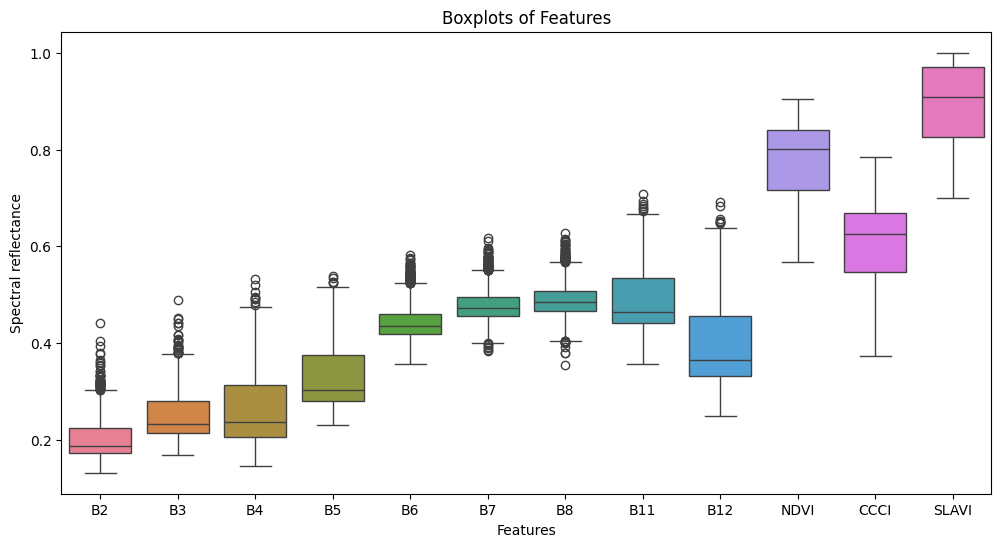

In [ ]:
# Import the seaborn library
import seaborn as sns

# Set the figure size
plt.figure(figsize=(12, 6))

# Create boxplots for each feature
sns.boxplot(data=train_df.drop(columns=['agbd']), orient='v')
plt.title('Boxplots of Features')
plt.xlabel('Features')
plt.ylabel('Spectral reflectance')
plt.show()

# Select and Train a Model Training
## Training a random forest regression model
We will start with a random forest regression model. Note that 'y_train' is now a column-vector. Therefore, we will use the ravel() function to change the shape of the target variable 'y_train' from a column-vector to a 1D array. In scikit-learn's RandomForestRegressor, the target variable y is expected to be a 1D.

The ravel() function is a method in NumPy, a popular numerical computing library in Python. It is used to flatten multi-dimensional arrays into a 1D array. When applied to a NumPy array, the ravel() function returns a contiguous flattened array containing the same elements as the input array.

We will tune the hyperparameters of the RF model. Parameters like n_estimators, max_depth, and min_samples_split can significantly impact the model's performance. We will use techniques like grid search or random search to find the optimal set of hyperparameters.

In [ ]:
# Set a random seed for reproducibility
np.random.seed(42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model to the data
grid_search.fit(X_train, y_train.values.ravel())

# Get the best parameters
best_params = grid_search.best_params_

Next, we will use the best parameters obtained from the grid search to train the final RF regression model (RandomForestRegressor).

In [ ]:
# Use the best parameters from the grid search
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']

# Initialize the RandomForestRegressor with the best parameters
best_rf_reg = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split
)

# Fit the model to the training data
best_rf_model = best_rf_reg.fit(X_train, y_train.values.ravel())

Next, we will use K-fold cross validation feature to split the training data into 10 subsets called folds. Then print the RMSE scores.

In [ ]:
# Calculate the RF model RMSE using cross-validation
neg_mse_scores = cross_val_score(best_rf_model, X_train, y_train.values.ravel(),
                                 scoring="neg_mean_squared_error", cv=10)

# Convert negative MSE to RMSE
rmse_scores = np.sqrt(-neg_mse_scores)

# Print or use the RMSE scores
print("RMSE Scores:", rmse_scores)

RMSE Scores: [20.29966236 19.43119742 23.19896345 21.64360992 21.93040595 19.78183326
 19.8218225  18.78815653 18.79075922 22.59839178]


Let's create a scatter plot for the RF model.


Mean Bias Error (MBE): 0.5870477983737173
Root Mean Square Error (RMSE): 20.188026840814953
R-squared (R2): 0.5056739053587667


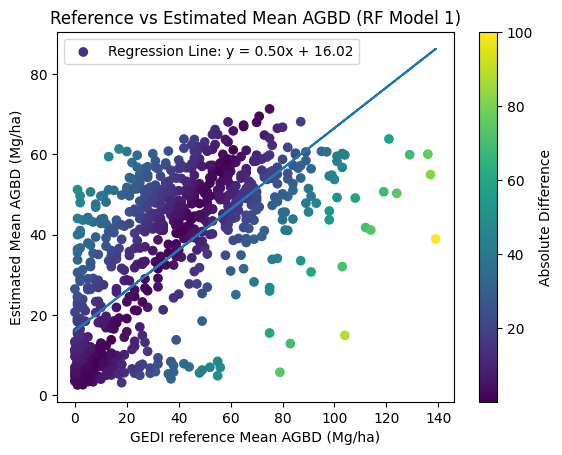

In [ ]:
# Predict test data
rf_prediction = best_rf_model.predict(X_test).flatten()
label = y_test.values.flatten()

# Calculate MBE
mbe = np.mean(rf_prediction - label)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(label, rf_prediction))

# Calculate R2
r2 = r2_score(label, rf_prediction)

print(f'Mean Bias Error (MBE): {mbe}')
print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

# Calculate the absolute difference between predicted and actual values
absolute_diff = np.abs(rf_prediction - label)

# Plot the scatter plot with colors based on the absolute difference
plt.scatter(label, rf_prediction, c=absolute_diff, cmap='viridis')
m, b = np.polyfit(label, rf_prediction, 1)
plt.plot(label, m * label + b)
plt.title('Reference vs Estimated Mean AGBD (RF Model 1)')
plt.xlabel('GEDI reference Mean AGBD (Mg/ha)')
plt.ylabel('Estimated Mean AGBD (Mg/ha)')
plt.colorbar(label='Absolute Difference')  # Adding a colorbar for reference
plt.legend(['Regression Line: y = {:.2f}x + {:.2f}'.format(m, b)])

plt.show()

## Save the Best RF Model
Let's save the best RF model parameters, feature names, or other metadata together.

In [ ]:
# joblib library or module.
import joblib

# Save the model
MODEL_PATH = '/content/drive/MyDrive/Maf_Datasets/best_rf_model.pkl'

model_package = {
    "model": best_rf_model,
    "features": FEATURES,
    "label": LABEL
}
joblib.dump(model_package, MODEL_PATH)

# Load with:
package = joblib.load(MODEL_PATH)
loaded_model = package["model"]

## Predict and display agbd map
Next, we will predict and display agbd map. Note that the final agbd image map will be exported as a GeoTIFF file, which can be visualized in any GIS software.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


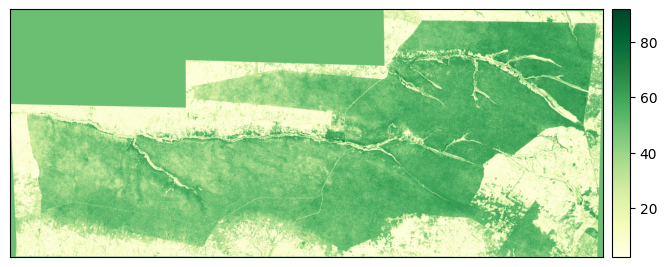

<Axes: >

In [ ]:
# Read all 12 bands from the image (assuming 12-band image)
image_input = []
for x in range(12):
    image_input.append(image.read(x + 1))
image_input = np.stack(image_input).reshape(12, -1).T  # shape: (pixels, features)

# Predict using the trained Random Forest model
rf_prediction = best_rf_model.predict(image_input)

# Reshape prediction to 2D image
rf_prediction = rf_prediction.reshape(shape[0], shape[1])

# Visualize the predicted raster
ep.plot_bands(rf_prediction, cmap='YlGn', figsize=plot_size)

Save the predicted AGBD map from the RF model as geotiff.

In [ ]:
# Save file to drive
save_location = '/content/drive/My Drive/Maf_Datasets/'
name = 'RF_Model_AGBD_2021a.tif'
location = save_location + name

new_dataset = rasterio.open(
      location,
      mode='w', driver='GTiff',
      height = rf_prediction.shape[0], width = rf_prediction.shape[1],
      count=1, dtype=str(rf_prediction.dtype),
      crs=crs,
      transform=transform
)
new_dataset.write(rf_prediction, 1);
new_dataset.close()